# AR map

## Imports

In [66]:
import xarray as xr
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

import cartopy.crs as ccrs # for projection
import cartopy.feature as cfeature # for map features
from cartopy.util import add_cyclic_point
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
#from matplotlib.colors import TwoSlopeNorm
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.pyplot as plt

## Inputs

In [9]:
filein = '/data/keeling/a/ctavila2/7_bootstrapping/gridmet_native_gridtmaxrhmin_oregon'

## Calculations

In [7]:
summer_fwi = xr.open_dataset(filein)
yearly_mean = summer_fwi.groupby('time.year').mean(dim='time')

In [52]:
poly_coeffs = yearly_mean.FWI.polyfit(dim="year", deg=1).rename({"polyfit_coefficients":"FWI"}) 
poly_fits = xr.polyval(coord=yearly_mean["year"], coeffs=poly_coeffs)
trendline = poly_coeffs.sel(degree=1).FWI

trendline_values = trendline * yearly_mean["year"] + poly_coeffs.sel(degree=0).FWI 
residuals = yearly_mean - trendline_values
residuals_df = residuals.to_dataframe()

In [80]:
grouped = residuals_df.groupby(["lat","lon"])
keys = list(grouped.groups.keys())
nloc = len(keys)

nlags = 10
lags = np.arange(nlags+1)
pacf_arr = np.full((nlags+1, nloc), np.nan)

for i, (lat, lon) in enumerate(keys):
    group_fwi = (grouped.get_group((lat, lon)).sort_values("year")["FWI"].values)
    
    if len(group_fwi) >= nlags+1:
        pacf_arr[:, i] = sm.tsa.pacf(group_fwi, nlags=nlags)

loc_index = pd.MultiIndex.from_tuples(keys, names=["lat","lon"])
pacf_flat = xr.DataArray(
    pacf_arr,
    dims=("lag","location"),
    coords={"lag": lags, "location": loc_index},
)

pacf_da = pacf_flat.unstack("location")

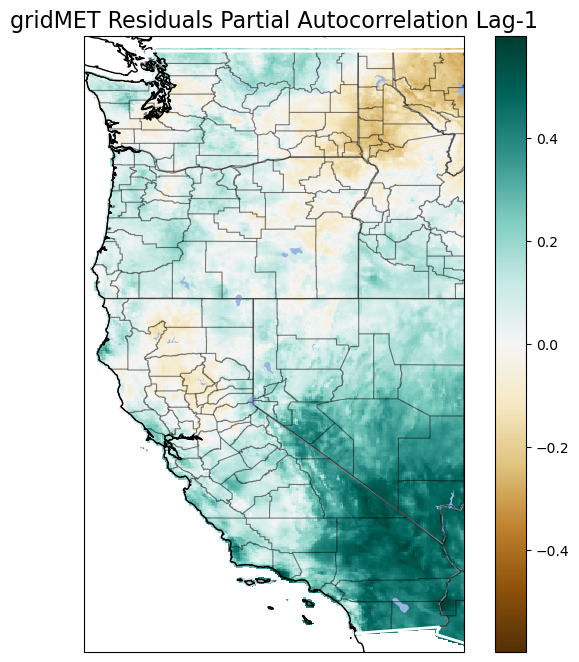

In [78]:
reader = shpreader.Reader('/data/keeling/a/ctavila2/2_maps/county_shapefile/countyl010g.shp')
counties = list(reader.geometries())

COUNTIES = cfeature.ShapelyFeature(counties, ccrs.PlateCarree())

scale = '110m'
states110 = cfeature.NaturalEarthFeature(
            category='cultural',
            name='admin_1_states_provinces_lines',
            scale=scale,
            facecolor='none',
            edgecolor='r')


cmap='BrBG'
lag_choice = 1
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': ccrs.PlateCarree()})

pacf_da.isel(lag=lag_choice).plot(ax=ax,cmap=cmap)


ax.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lines', '110m', edgecolor='gray', facecolor='none'))
ax.coastlines()
ax.add_feature(cfeature.LAKES)
ax.add_feature(COUNTIES, linewidth=0.8, alpha=0.5, facecolor='none', edgecolor='black')
ax.add_feature(cfeature.BORDERS, linewidth=2, edgecolor='white')


plt.title(f'gridMET Residuals Partial Autocorrelation Lag-{lag_choice}', fontsize=16)
plt.savefig(f'/data/keeling/a/ctavila2/2024_FWI_CMIP5_Ensemble_Avila/revision_notebooks/revision_figures/0_Partial_AutoCorr_Lag_{lag_choice}')


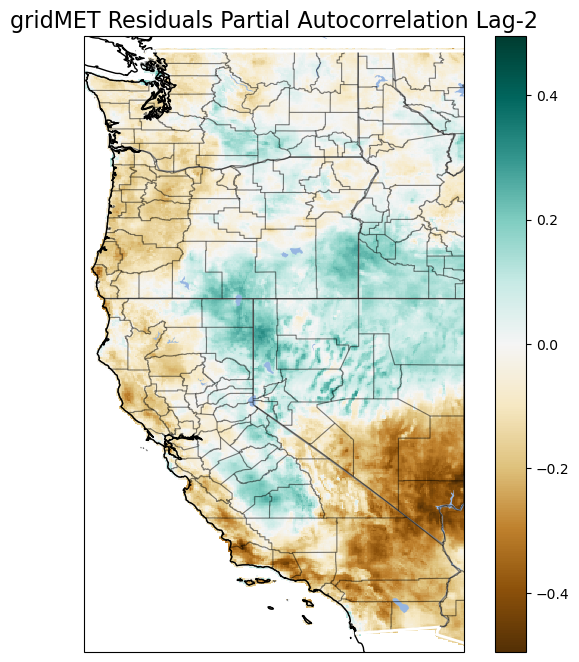

In [79]:
reader = shpreader.Reader('/data/keeling/a/ctavila2/2_maps/county_shapefile/countyl010g.shp')
counties = list(reader.geometries())

COUNTIES = cfeature.ShapelyFeature(counties, ccrs.PlateCarree())

scale = '110m'
states110 = cfeature.NaturalEarthFeature(
            category='cultural',
            name='admin_1_states_provinces_lines',
            scale=scale,
            facecolor='none',
            edgecolor='r')


cmap='BrBG'
lag_choice = 2
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': ccrs.PlateCarree()})

pacf_da.isel(lag=lag_choice).plot(ax=ax,cmap=cmap)


ax.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lines', '110m', edgecolor='gray', facecolor='none'))
ax.coastlines()
ax.add_feature(cfeature.LAKES)
ax.add_feature(COUNTIES, linewidth=0.8, alpha=0.5, facecolor='none', edgecolor='black')
ax.add_feature(cfeature.BORDERS, linewidth=2, edgecolor='white')


plt.title(f'gridMET Residuals Partial Autocorrelation Lag-{lag_choice}', fontsize=16)
plt.savefig(f'/data/keeling/a/ctavila2/2024_FWI_CMIP5_Ensemble_Avila/revision_notebooks/revision_figures/0_Partial_AutoCorr_Lag_{lag_choice}')
